In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [39]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [40]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values

In [43]:
train_labels

array([1, 0, 1, ..., 7, 6, 9])

In [44]:
train_images.shape

(42000, 784)

In [45]:
test_images = test_df.values

In [46]:
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

In [48]:
test_images.shape

(28000, 784)

In [49]:
#Reshape to image tensors
train_images = train_images.reshape(-1,28,28)
test_images = test_images.reshape(-1,28,28)

In [50]:
print(f"Train images: {train_images.shape}, Train labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}")

Train images: (42000, 28, 28), Train labels: (42000,)
Test images: (28000, 28, 28)


In [51]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, stratify = train_labels,
                                                 random_state = seed)
print(f"Train split: {x_train.shape}, Validation split: {x_val.shape}")

Train split: (33600, 28, 28), Validation split: (8400, 28, 28)


In [53]:

class MNISTDataset(Dataset):
    def __init__(self, images, labels = None, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            return img
            

In [54]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))  
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))  
])

In [55]:
train_dataset = MNISTDataset(x_train, y_train, transform = train_transform)
val_dataset = MNISTDataset(x_val, y_val, transform = test_transform)
test_dataset = MNISTDataset(test_images, labels = None, transform = test_transform)

In [56]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

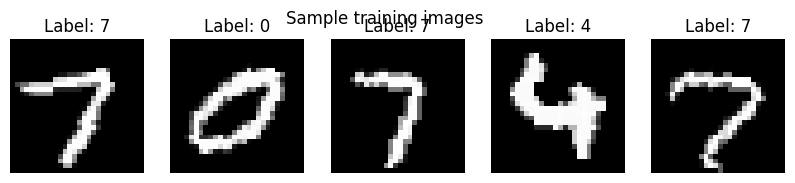

In [57]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1,5, figsize = (10,2))
for i in range(5):
    ax = axes[i]
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap = 'gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.suptitle('Sample training images')
plt.show()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1,32,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7 , 128),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.5),
            nn.Linear(128,64),
            nn.ReLU(inplace = True),
            nn.Linear(64,10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_fea

In [20]:
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [22]:
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images , labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    

Epoch 1/50: Train Loss = 0.5904, Val Loss = 0.5445, Val Acc = 0.9899
Epoch 2/50: Train Loss = 0.5804, Val Loss = 0.5472, Val Acc = 0.9910
Epoch 3/50: Train Loss = 0.5757, Val Loss = 0.5530, Val Acc = 0.9902
Epoch 4/50: Train Loss = 0.5719, Val Loss = 0.5786, Val Acc = 0.9905
Epoch 5/50: Train Loss = 0.5692, Val Loss = 0.5577, Val Acc = 0.9913
Epoch 6/50: Train Loss = 0.5658, Val Loss = 0.5632, Val Acc = 0.9933
Epoch 7/50: Train Loss = 0.5591, Val Loss = 0.5705, Val Acc = 0.9933
Epoch 8/50: Train Loss = 0.5578, Val Loss = 0.5616, Val Acc = 0.9923
Epoch 9/50: Train Loss = 0.5545, Val Loss = 0.5708, Val Acc = 0.9919
Epoch 10/50: Train Loss = 0.5517, Val Loss = 0.5780, Val Acc = 0.9930
Epoch 11/50: Train Loss = 0.5492, Val Loss = 0.5771, Val Acc = 0.9944
Epoch 12/50: Train Loss = 0.5452, Val Loss = 0.5666, Val Acc = 0.9937
Epoch 13/50: Train Loss = 0.5432, Val Loss = 0.5512, Val Acc = 0.9927
Epoch 14/50: Train Loss = 0.5400, Val Loss = 0.5662, Val Acc = 0.9936
Epoch 15/50: Train Loss = 0.5

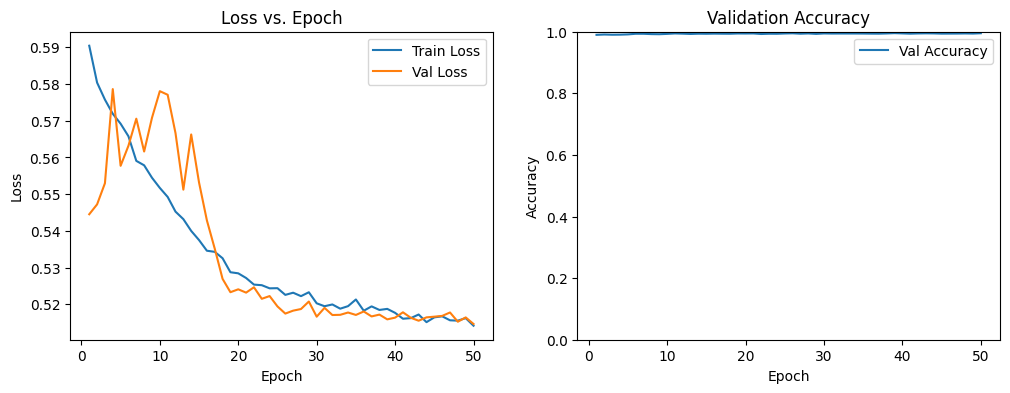

In [23]:
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0); plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [24]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[825   0   0   0   0   0   1   0   0   1]
 [  0 935   0   0   0   0   0   2   0   0]
 [  0   0 831   0   1   0   0   3   0   0]
 [  1   0   1 862   0   2   0   1   2   1]
 [  0   1   0   0 811   0   0   0   0   2]
 [  0   0   0   1   0 753   1   0   3   1]
 [  0   0   0   0   2   1 824   0   0   0]
 [  0   2   0   0   2   0   0 876   0   0]
 [  0   0   0   0   0   0   0   0 810   3]
 [  1   0   0   0   1   1   0   2   1 832]]


In [25]:
# Normalize confusion matrix for visualization (optional)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
print("Per-class accuracy:", np.diag(cm_norm))

Per-class accuracy: [0.99758162 0.99786553 0.99520958 0.9908046  0.9963145  0.99209486
 0.99637243 0.99545455 0.99630996 0.9928401 ]


In [59]:
model.eval()
image_ids = []
predictions = []

with torch.no_grad():
    for i, images in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        # Compute the corresponding ImageIds for this batch
        start_id = i * BATCH_SIZE + 1
        for offset, pred in enumerate(preds):
            image_ids.append(start_id + offset)
            predictions.append(pred)

submission_df = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
#submission_df.to_csv("submission.csv", index=False)
print(submission_df.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


In [60]:
submission_df['Label'].unique()

array([2, 0, 9, 3, 7, 5, 4, 1, 6, 8])